In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import glob
from statsmodels.stats import outliers_influence
import statsmodels.stats.multitest as multi
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statannot
import scipy.stats
import itertools
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
bayesfactor = importr('BayesFactor')     # ToDo: get this to work again

import multiprocessing as mp
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [ ]:
ahead_long = pd.read_csv('../data/final_data/AHEAD_and_CRUISE_and_ICV-combined-long.csv')
ahead_long.head()

#### let's pretend FX & cerebellum are left hemisphere - makes plotting a bit easier
ahead_long.loc[ahead_long['ROI'] == 'FX', 'hemisphere'] = 'L'
ahead_long.loc[ahead_long['ROI'] == 'Cerebellum', 'hemisphere'] = 'L'

#### Reformat data

Get rid of all measures that are not median or IQR

In [3]:
qMRI_data = ahead_long.loc[(ahead_long.Intensity.isin(['iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'qpd', 'thickness'])) & (ahead_long.Measure.isin(['Median_intensity', 'IQR_intensity']))]#'IQR_relative_to_median']))]
qMRI_data['Statistic'] = qMRI_data['Measure'].apply(lambda x: x.lower().split('_')[0])
qMRI_data.head()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Measure,Segmentation,Age,Sexe,ROI,ROI2,hemisphere,icv,Intensity,Value,Statistic
0,IQR_intensity,sub-000,22.0,f,AMG L,AMG,L,1408505.6,iron,2.810272,iqr
1,IQR_intensity,sub-000,22.0,f,AMG R,AMG,R,1408505.6,iron,3.357533,iqr
2,IQR_intensity,sub-000,22.0,f,CL L,CL,L,1408505.6,iron,2.503479,iqr
3,IQR_intensity,sub-000,22.0,f,CL R,CL,R,1408505.6,iron,2.038232,iqr
4,IQR_intensity,sub-000,22.0,f,Cerebellum,Cerebellum,L,1408505.6,iron,5.302089,iqr


# Test for global between-sex differences

In [4]:
qMRI_by_sex = qMRI_data.loc[qMRI_data.Intensity.isin(['myelin', 'thickness'])].groupby(['Measure', 'ROI', 'ROI2', 'hemisphere', 'Intensity', 'Statistic', 'Sexe', 'icv'])['Value'].mean().reset_index()

Statistical tests, multiple comparison correction (FDR)

In [5]:
all_tests = []
for (qmri, statistic, roi), _ in qMRI_by_sex.groupby(['Intensity', 'Statistic', 'ROI']):
    idx_datadf = (qMRI_by_sex.Intensity == qmri) & (qMRI_by_sex.ROI == roi) & (qMRI_by_sex.Statistic == statistic) #& ~(tmp.is_outlier)
    vals_m = qMRI_by_sex.loc[(idx_datadf) & (qMRI_by_sex.Sexe=='m'), 'Value']
    vals_f = qMRI_by_sex.loc[(idx_datadf) & (qMRI_by_sex.Sexe=='f'), 'Value']
    t,p = scipy.stats.ttest_ind(vals_m, vals_f)
#    print('ROI {}, {} {}, t({}) = {}, p = {}, d = {}'.format(roi, qmri, statistic, idx_datadf.sum()-1, np.round(t, 3), np.round(p, 3), np.round(vals.mean()/vals.std(), 3)))
    all_tests.append(pd.DataFrame({'roi': roi, 'qmri': qmri, 'statistic': statistic, 't': t, 'p': p}, index=[0]))

# combine in dataframe, calculate FDR-corrected p-value and significance
inter_sex_ttests = pd.concat(all_tests)
for qmri in np.unique(inter_sex_ttests.qmri):
    for stat in np.unique(inter_sex_ttests.statistic):
        idx = (inter_sex_ttests['qmri'] == qmri) & (inter_sex_ttests['statistic'] == stat) & (pd.notnull(inter_sex_ttests.p))
        ps = inter_sex_ttests.loc[idx, 'p'].values
        inter_sex_ttests.loc[idx, 'p_corrected'] = multi.multipletests(ps, method='fdr_bh')[1]
        inter_sex_ttests.loc[idx, 'sign'] = multi.multipletests(ps, method='fdr_bh')[0]
# inter_sex_ttests.loc[inter_sex_ttests.sign == True]

# Add info for plotting (x-axis position 'xpos' for annotation 's')
match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
xticklabels = qMRI_by_sex['ROI'].unique().tolist()  #tmp['ROI'].unique().tolist() # [x._text for x in fac.axes[2][0].get_xticklabels()]
xpos = match(inter_sex_ttests.loc[inter_sex_ttests.sign==True].roi, xticklabels)
inter_sex_ttests.loc[inter_sex_ttests.sign==True, 'xpos'] = xpos

inter_sex_ttests['s'] = 'ns'
inter_sex_ttests.loc[inter_sex_ttests.p_corrected < 0.001, 's'] = '***'
inter_sex_ttests.loc[(inter_sex_ttests.p_corrected > 0.001) & (inter_sex_ttests.p_corrected < 0.01), 's'] = '**'
inter_sex_ttests.loc[(inter_sex_ttests.p_corrected > 0.01) & (inter_sex_ttests.p_corrected < 0.05), 's'] = '*'

Plot

In [6]:
qMRI_by_sex['Sexe'] = qMRI_by_sex['Sexe'].replace({'f': 'Female', 'm': 'Male'})

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/seaborn/axisgrid.py:650: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PAG L_Female v.s. PAG L_Male: Custom statistical test, P_val:3.788e-02
PAG R_Female v.s. PAG R_Male: Custom statistical test, P_val:1.320e-02
PPN L_Female v.s. PPN L_Male: Custom statistical test, P_val:1.320e-02
PPN R_Female v.s. PPN R_Male: Custom statistical test, P_val:1.320e-02
SN L_Female v.s. SN L_Male: Custom statistical test, P_val:1.791e-02
STN R_Female v.s. STN R_Male: Custom statistical test, P_val:3.618e-02
AMG R_Female v.s. AMG R_Male: Custom statistical test, P_val:3.291e-02
CL L_Female v.s. CL L_Male: Custom statistical test, P_val:1.320e-02
VTA L_Female v.s. VTA L_Male: Custom statistical test, P_val:9.123e-03
VTA R_Female v.s. VTA R_Male: Custom statistical test, P_val:1.320e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p

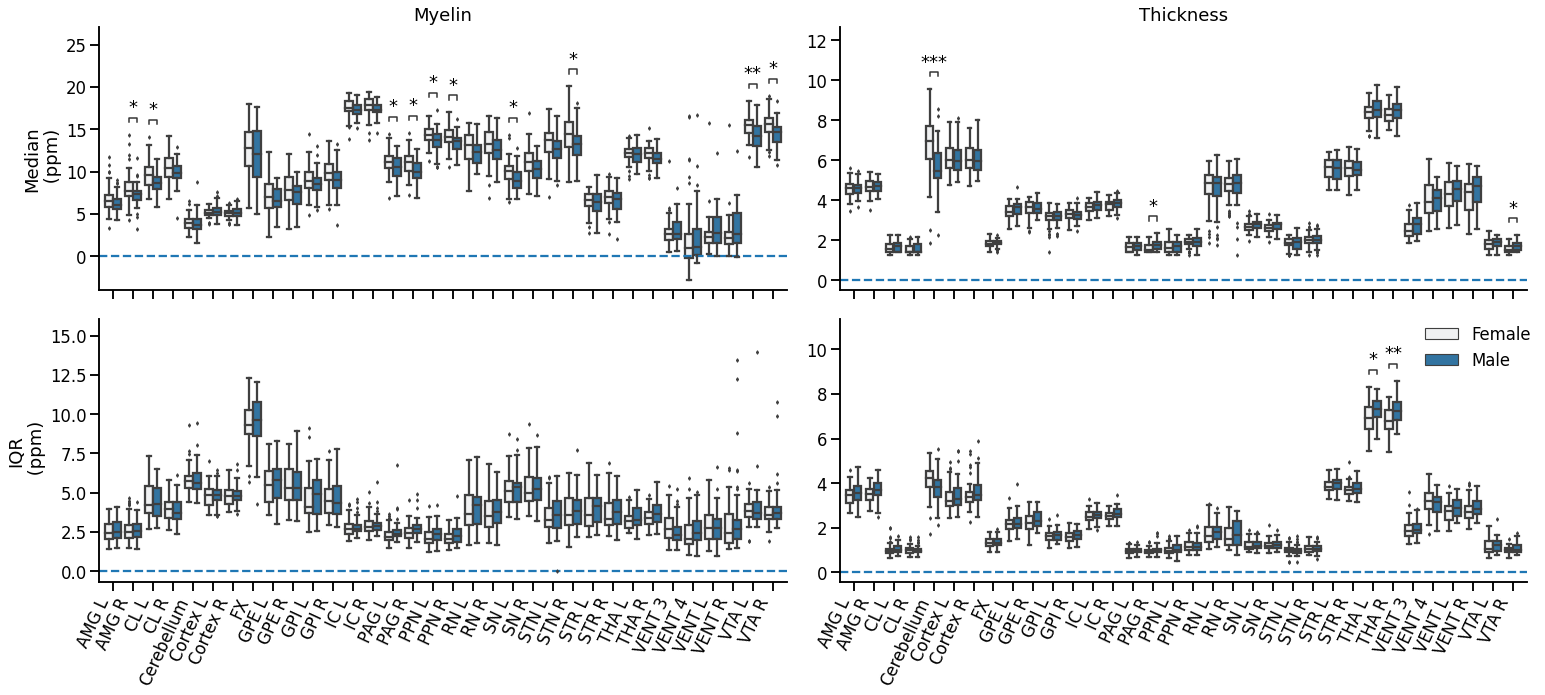

In [7]:
width = 10
aspect = 2
sns.set_context('talk')
#qMRI_by_sex_exclude = (qMRI_by_sex.Measure == 'IQR_relative_to_median') & (qMRI_by_sex.Value > 10)
# fac = sns.FacetGrid(data=qMRI_by_sex.loc[~(qMRI_by_sex_exclude)], col='Intensity', row='Statistic', row_order=['median', 'iqr'], 
#                     sharex=True, sharey=False, height=width/aspect, aspect=aspect, despine=True)
fac = sns.FacetGrid(data=qMRI_by_sex, col='Intensity', row='Statistic', row_order=['median', 'iqr'], 
                    sharex=True, sharey=False, height=width/aspect, aspect=aspect, despine=True)
fac.map(plt.axhline, y=0, linestyle='--')
fac.map(sns.boxplot, 'ROI', 'Value', 'Sexe', fliersize=2.5, order=qMRI_by_sex['ROI'].unique())
fac.add_legend()
# fac.axes[1][0].set_ylim([0,2.5])

#qMRI_by_sex_exclude = (qMRI_by_sex.Measure == 'IQR_relative_to_median') & (qMRI_by_sex.Value > 10)
# annotations
for col_, qmri in enumerate(['myelin', 'thickness']):
    for row_, stat in enumerate(['median', 'iqr']):
        these_sign_df = inter_sex_ttests.loc[(inter_sex_ttests.sign==True) & (inter_sex_ttests.qmri==qmri) & (inter_sex_ttests.statistic==stat)]
        all_bars = []
        for index, row in these_sign_df.iterrows():
            all_bars.append(((row['roi'], 'Female'),(row['roi'], 'Male')))
        
        if len(all_bars) > 0:
            test_results = statannot.add_stat_annotation(fac.axes[row_][col_], data=qMRI_by_sex.loc[(qMRI_by_sex.Intensity==qmri) & (qMRI_by_sex.Statistic == stat)], 
                                                         x='ROI', y='Value', hue='Sexe', order=qMRI_by_sex.ROI.unique(),
                                                         box_pairs=all_bars, perform_stat_test=False, pvalues=these_sign_df['p_corrected'].values, test_short_name='test',
                                                         text_format='star', # line_offset_to_box=0.02,
                                                         loc='inside', verbose=2)
        fac.axes[row_][col_].set_ylim(fac.axes[row_][col_].get_ylim()[0], fac.axes[row_][col_].get_ylim()[1]*1.1)


# Further layout
fac.map(plt.xticks, rotation=65, horizontalalignment='right', color='k')
fac.axes[0][0].set_title('Myelin')
fac.axes[0][1].set_title('Thickness')
fac.axes[1][0].set_title('')
fac.axes[1][1].set_title('')
fac.axes[0][0].set_ylabel('Median\n (ppm)')
fac.axes[1][0].set_ylabel('IQR\n (ppm)')

plt.gcf().tight_layout()
plt.savefig('./figures/intersex_differences.pdf')

# Test for global interhemisphere differences

In [8]:
import scipy

def find_y_from_x(lines, x):
    all_y = []
    for line in lines:
        if len(line._x) > 0:
            if line._x[0] == x:
                all_y = np.hstack([all_y, line._y])
    if len(all_y) > 0:
        return np.max(all_y)
    else:
        return 0

# def do_paired_ttest(x):
#     t, p = scipy.stats.ttest_rel(x.loc[x['hemisphere']=='L','Value'], x.loc[x['hemisphere']=='R','Value'])
#     return pd.Series({'t': t, 'p': p})

def get_difference(x):
    is_left = x['hemisphere']=='L'
    return pd.DataFrame({'Segmentation': x.loc[is_left, 'Segmentation'].values,
                         'Age': x.loc[is_left, 'Age'].values,
                         'Sexe': x.loc[is_left, 'Sexe'].values,
                         'icv': x.loc[is_left, 'icv'].values,
                         'Difference': x.loc[x['hemisphere']=='L','Value'].values - x.loc[x['hemisphere']=='R','Value'].values})
def find_outliers(x, n_iqr=3):
    xmed = x.median()
    iqr = x.quantile(0.75) - x.quantile(0.25)
    is_outlier = (x < (xmed - n_iqr*iqr)) | (x > (xmed + n_iqr*iqr))
    return is_outlier

qMRI_data_2hemispheres = qMRI_data.loc[qMRI_data['ROI'].apply(lambda x: x.endswith(' R') or x.endswith(' L'))]    
inter_hemisphere_differences = qMRI_data_2hemispheres.groupby(['Intensity', 'Statistic', 'ROI2']).apply(lambda x: get_difference(x)).reset_index()
inter_hemisphere_differences['is_outlier'] = inter_hemisphere_differences.groupby(['Intensity', 'Statistic', 'ROI2'])['Difference'].apply(lambda x: find_outliers(x))

tmp = inter_hemisphere_differences.loc[inter_hemisphere_differences.Intensity.isin(['iron', 'myelin', 'thickness'])]
tmp['ROI'] = tmp['ROI2']
tmp['ROI'] = tmp['ROI'].replace({'Cortex': 'Ctx'})

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Statistical test

In [9]:
all_tests = []
for (qmri, statistic, roi), _ in tmp.groupby(['Intensity', 'Statistic', 'ROI']):
    idx_datadf = (tmp.Intensity == qmri) & (tmp.ROI2 == roi) & (tmp.Statistic == statistic) & ~(tmp.is_outlier)
    vals = tmp.loc[idx_datadf, 'Difference']
    t,p = scipy.stats.ttest_1samp(vals, 0)
#    print('ROI {}, {} {}, t({}) = {}, p = {}, d = {}'.format(roi, qmri, statistic, idx_datadf.sum()-1, np.round(t, 3), np.round(p, 3), np.round(vals.mean()/vals.std(), 3)))
    all_tests.append(pd.DataFrame({'roi': roi, 'qmri': qmri, 'statistic': statistic, 't': t, 'p': p}, index=[0]))

# combine in dataframe, calculate FDR-corrected p-value and significance
inter_hemi_ttests = pd.concat(all_tests)
for qmri in np.unique(inter_hemi_ttests.qmri):
    for stat in np.unique(inter_hemi_ttests.statistic):
        idx = (inter_hemi_ttests['qmri'] == qmri) & (inter_hemi_ttests['statistic'] == stat) & (pd.notnull(inter_hemi_ttests.p))
        ps = inter_hemi_ttests.loc[idx, 'p'].values
        inter_hemi_ttests.loc[idx, 'p_corrected'] = multi.multipletests(ps, method='fdr_bh')[1]
        inter_hemi_ttests.loc[idx, 'sign'] = multi.multipletests(ps, method='fdr_bh')[0]
#inter_hemi_ttests.loc[inter_hemi_ttests.sign == True]

# Add info for plotting (x-axis position 'xpos' for annotation 's')
match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
xticklabels = tmp['ROI'].unique().tolist() # [x._text for x in fac.axes[2][0].get_xticklabels()]
xpos = match(inter_hemi_ttests.loc[inter_hemi_ttests.sign==True].roi, xticklabels)
inter_hemi_ttests.loc[inter_hemi_ttests.sign==True, 'xpos'] = xpos

inter_hemi_ttests['s'] = 'ns'
inter_hemi_ttests.loc[inter_hemi_ttests.p_corrected < 0.001, 's'] = '***'
inter_hemi_ttests.loc[(inter_hemi_ttests.p_corrected > 0.001) & (inter_hemi_ttests.p_corrected < 0.01), 's'] = '**'
inter_hemi_ttests.loc[(inter_hemi_ttests.p_corrected > 0.01) & (inter_hemi_ttests.p_corrected < 0.05), 's'] = '*'

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plot

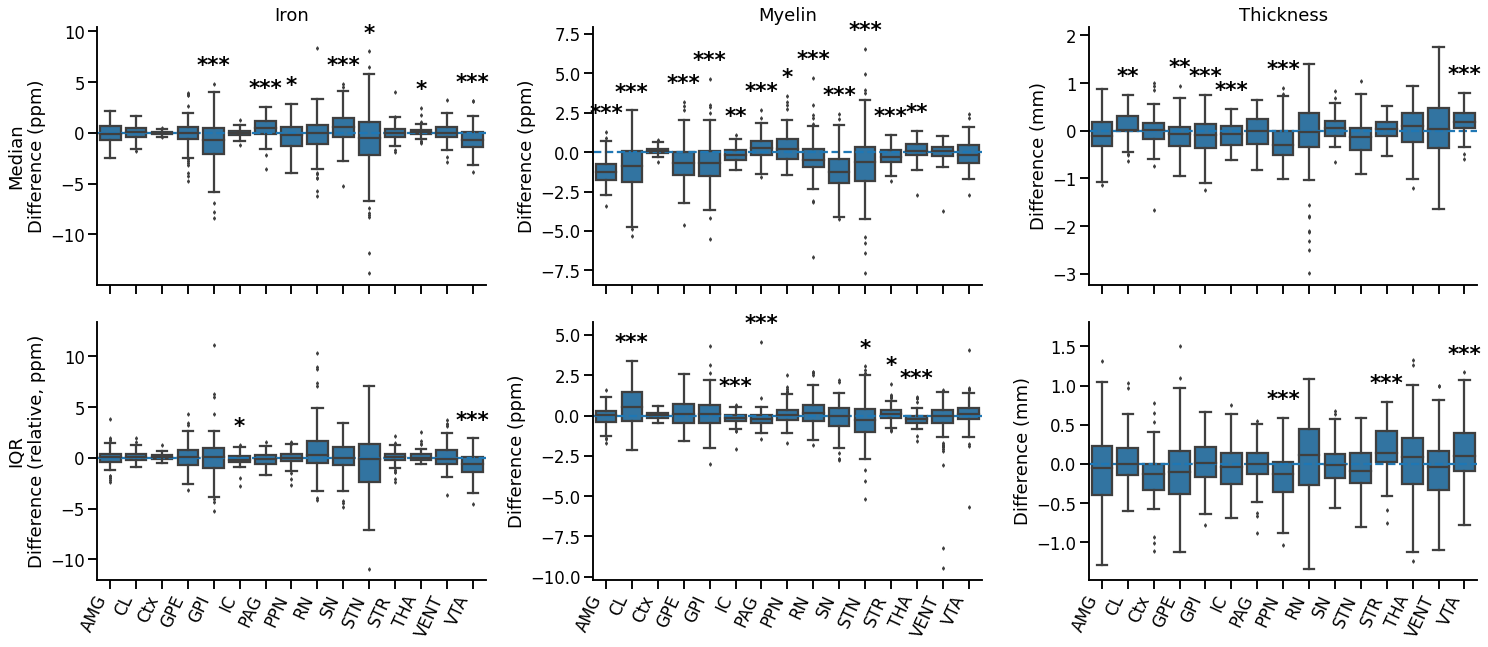

In [10]:
width = 7
aspect = 1.5
sns.set_context('talk')
fac = sns.FacetGrid(data=tmp, col='Intensity', row='Statistic', row_order=['median', 'iqr'], 
                    sharex=True, sharey=False, height=width/aspect, aspect=aspect, despine=True)
fac.map(plt.axhline, y=0, linestyle='--')
fac.map(sns.boxplot, 'ROI', 'Difference', fliersize=2.5, order=tmp['ROI'].unique())

# annotations
for col_, qmri in enumerate(['iron', 'myelin', 'thickness']):
    for row_, stat in enumerate(['median', 'iqr']):
        for index, row in inter_hemi_ttests.loc[(inter_hemi_ttests.sign==True) & (inter_hemi_ttests.qmri==qmri) & (inter_hemi_ttests.statistic==stat)].iterrows():
            maxy = find_y_from_x(fac.axes[row_][col_].lines, row['xpos'])
#             if row_ == 1 and col_ == 1:  # hard-code for IQR difference
#                 ylimdiff = 2
#             else:
            ylimdiff = fac.axes[row_][col_].get_ylim()[1]-fac.axes[row_][col_].get_ylim()[0]
            fac.axes[row_][col_].text(x=row['xpos'], y=maxy+.05*ylimdiff, s=row['s'], horizontalalignment='center', size='large', color='black', weight='semibold')
        fac.axes[row_][col_].set_ylim(fac.axes[row_][col_].get_ylim()[0], fac.axes[row_][col_].get_ylim()[1]*1.1)

# Further layout
fac.map(plt.xticks, rotation=65, horizontalalignment='right', color='k')
fac.axes[0][0].set_title('Iron')
fac.axes[0][1].set_title('Myelin')
fac.axes[0][2].set_title('Thickness')
fac.axes[1][0].set_title('')
fac.axes[1][1].set_title('')
fac.axes[1][2].set_title('')
fac.axes[0][0].set_ylabel('Median\nDifference (ppm)')
fac.axes[1][0].set_ylabel('IQR\nDifference (relative, ppm)')
fac.axes[0][1].set_ylabel('Difference (ppm)')
fac.axes[1][1].set_ylabel('Difference (ppm)')
fac.axes[0][2].set_ylabel('Difference (mm)')
fac.axes[1][2].set_ylabel('Difference (mm)')

#fac.axes[1][1].set_ylim([-1,2])


plt.gcf().tight_layout()
plt.savefig('./figures/interhemisphere_differences.pdf')